In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# https://github.com/mithunraj984
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e1/sample_submission.csv
/kaggle/input/playground-series-s3e1/train.csv
/kaggle/input/playground-series-s3e1/test.csv


In [2]:
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

%matplotlib inline

In [3]:
train_df = pd.read_csv('/kaggle/input/playground-series-s3e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s3e1/test.csv')
submission_df = pd.read_csv('/kaggle/input/playground-series-s3e1/sample_submission.csv')
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

## EDA

In [4]:
train_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,2.3859,15.0,3.827160,1.112100,1280.0,2.486989,34.60,-120.12,0.980
1,3.7188,17.0,6.013373,1.054217,1504.0,3.813084,38.69,-121.22,0.946
2,4.7750,27.0,6.535604,1.103175,1061.0,2.464602,34.71,-120.45,1.576
3,2.4138,16.0,3.350203,0.965432,1255.0,2.089286,32.66,-117.09,1.336
4,3.7500,52.0,4.284404,1.069246,1793.0,1.604790,37.80,-122.41,4.500


In [5]:
train_df.shape[0], test_df.shape[0], submission_df.shape[0]

(37137, 24759, 24759)

In [6]:
profile = ProfileReport(train_df, title="Pandas Profiling Report")
# profile

In [7]:
correlations = profile.description_set["correlations"]
print(correlations['pearson']['MedHouseVal'].sort_values(ascending=False), '\n\n')
print(correlations['spearman']['MedHouseVal'].sort_values(ascending=False), '\n\n')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

MedHouseVal    1.000000
MedInc         0.701925
AveRooms       0.366727
HouseAge       0.103210
Population    -0.038479
AveOccup      -0.048475
Longitude     -0.056742
AveBedrms     -0.067487
Latitude      -0.116499
Name: MedHouseVal, dtype: float64 


MedHouseVal    1.000000
MedInc         0.697265
AveRooms       0.309516
HouseAge       0.062783
Population    -0.042108
Longitude     -0.113271
AveBedrms     -0.121262
Latitude      -0.132997
AveOccup      -0.224818
Name: MedHouseVal, dtype: float64 




In [8]:
!pip install dython

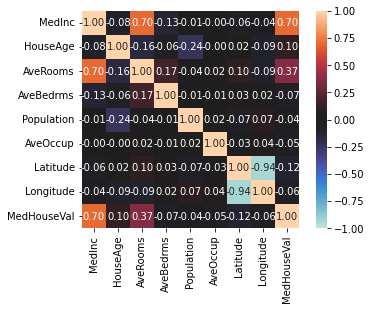

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.080542,0.699994,-0.127169,-0.008552,-0.000885,-0.060463,-0.043742,0.701925
HouseAge,-0.080542,1.000000,-0.156625,-0.056960,-0.235459,-0.002792,0.021071,-0.090394,0.103210
AveRooms,0.699994,-0.156625,1.000000,0.174753,-0.038099,0.023858,0.095169,-0.088184,0.366727
AveBedrms,-0.127169,-0.056960,0.174753,1.000000,-0.007120,-0.009257,0.026142,0.015218,-0.067487
Population,-0.008552,-0.235459,-0.038099,-0.007120,1.000000,0.022825,-0.069944,0.071085,-0.038479
AveOccup,-0.000885,-0.002792,0.023858,-0.009257,0.022825,1.000000,-0.032199,0.037118,-0.048475
Latitude,-0.060463,0.021071,0.095169,0.026142,-0.069944,-0.032199,1.000000,-0.937370,-0.116499
Longitude,-0.043742,-0.090394,-0.088184,0.015218,0.071085,0.037118,-0.937370,1.000000,-0.056742
MedHouseVal,0.701925,0.103210,0.366727,-0.067487,-0.038479,-0.048475,-0.116499,-0.056742,1.000000


In [9]:
from dython.nominal import associations

associations(train_df)['corr']

## Feature Engineering

TODO:
- additional training data - DONE
- additional feature MedInc / Population - DONE
- additional features long/lat-itude - DONE
- remove outliers - DONE

TODO v2:
- categorical features long/lat-itude - DONE
- scaling for NN - DONE

In [10]:
original_df = fetch_california_housing(as_frame=True)['frame']
train_df['is_generated'] = 1
test_df['is_generated'] = 1
original_df['is_generated'] = 0
train_df = pd.concat([train_df, original_df]).reset_index(drop=True)

### (Long/Lat)itude features engineering

based on: https://bmanikan.medium.com/feature-engineering-all-i-learned-about-geo-spatial-features-649871d16796

In [11]:
train_df['r'] = np.sqrt(train_df['Latitude']**2 + train_df['Longitude']**2)
train_df['theta'] = np.arctan2(train_df['Latitude'], train_df['Longitude'])

test_df['r'] = np.sqrt(test_df['Latitude']**2 + test_df['Longitude']**2)
test_df['theta'] = np.arctan2(test_df['Latitude'], test_df['Longitude'])

In [12]:
train_df['rot_15_x'] = (np.cos(np.radians(15)) * train_df['Longitude']) + (np.sin(np.radians(15)) * train_df['Latitude'])
train_df['rot_15_y'] = (np.cos(np.radians(15)) * train_df['Latitude']) - (np.sin(np.radians(15)) * train_df['Longitude'])

train_df['rot_30_x'] = (np.cos(np.radians(30)) * train_df['Longitude']) + (np.sin(np.radians(30)) * train_df['Latitude'])
train_df['rot_30_y'] = (np.cos(np.radians(30)) * train_df['Latitude']) - (np.sin(np.radians(30)) * train_df['Longitude'])

train_df['rot_45_x'] = (np.cos(np.radians(45)) * train_df['Longitude']) + (np.sin(np.radians(45)) * train_df['Latitude'])
train_df['rot_45_y'] = (np.cos(np.radians(45)) * train_df['Latitude']) - (np.sin(np.radians(45)) * train_df['Longitude'])

In [13]:
test_df['rot_15_x'] = (np.cos(np.radians(15)) * test_df['Longitude']) + (np.sin(np.radians(15)) * test_df['Latitude'])
test_df['rot_15_y'] = (np.cos(np.radians(15)) * test_df['Latitude']) - (np.sin(np.radians(15)) * test_df['Longitude'])

test_df['rot_30_x'] = (np.cos(np.radians(30)) * test_df['Longitude']) + (np.sin(np.radians(30)) * test_df['Latitude'])
test_df['rot_30_y'] = (np.cos(np.radians(30)) * test_df['Latitude']) - (np.sin(np.radians(30)) * test_df['Longitude'])

test_df['rot_45_x'] = (np.cos(np.radians(45)) * test_df['Longitude']) + (np.sin(np.radians(45)) * test_df['Latitude'])
test_df['rot_45_y'] = (np.cos(np.radians(45)) * test_df['Latitude']) - (np.sin(np.radians(45)) * test_df['Longitude'])

In [14]:
from sklearn.decomposition import PCA

def pca(data):
    '''
    input: dataframe containing Latitude(x) and Longitude(y)
    '''
    coordinates = data[['Latitude','Latitude']].values
    pca_obj = PCA().fit(coordinates)
    pca_x = pca_obj.transform(data[['Latitude', 'Longitude']].values)[:,0]
    pca_y = pca_obj.transform(data[['Latitude', 'Longitude']].values)[:,1]
    return pca_x, pca_y

train_df['pca_x'], train_df['pca_y'] = pca(train_df)
test_df['pca_x'], test_df['pca_y'] = pca(test_df)

In [15]:
!pip install reverse_geocoder --quiet

In [16]:
import reverse_geocoder as rg

def geocoder(data):
    '''
    input: dataframe containing Latitude(x) and Longitude(y) coordinates
    output: JSON data containing info on available building or street names.
    '''
    coordinates = list(zip(data['Latitude'].values, data['Longitude'].values))
    results = rg.search(coordinates) # default mode = 2
    return results

In [17]:
def get_values(df, column):
    return df[column].value_counts(normalize=True)[df[column].value_counts(normalize=True) < 0.005].index.tolist()

geocoder_data = geocoder(train_df)

train_df['admin2'] = [val['admin2'] for val in geocoder_data]
train_df['admin2'][train_df['admin2'].isin(get_values(train_df, 'admin2'))] = 'Other'
train_df['admin2'].value_counts()

geocoder_data = geocoder(test_df)

test_df['admin2'] = [val['admin2'] for val in geocoder_data]
test_df['admin2'][test_df['admin2'].isin(get_values(test_df, 'admin2'))] = 'Other'
test_df['admin2'].value_counts()

Loading formatted geocoded file...


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Los Angeles County       7344
Orange County            2114
San Diego County         1869
Santa Clara County       1481
Alameda County           1316
Sacramento County        1250
Other                    1131
San Bernardino County     959
Contra Costa County       861
Riverside County          786
San Mateo County          725
San Francisco County      586
Fresno County             551
San Joaquin County        538
Ventura County            384
Kern County               365
Stanislaus County         317
Sonoma County             250
Santa Barbara County      245
Tulare County             213
Solano County             207
Marin County              201
Monterey County           164
Shasta County             161
Butte County              161
Merced County             146
Santa Cruz County         145
Napa County               145
Yolo County               144
Name: admin2, dtype: int64

## Modeling

TODO:
- CV vs Hold-out - DONE
- RF (baseline) - DONE
- CatBoost - DONE

TODO v2:
- Feedforward NN - DONE (didn't work best tho)
- Ensemble CatBoost / LightGBM/ NN - PARTLY DONE

In [18]:
y = train_df['MedHouseVal']
X = train_df.drop(['MedHouseVal'], axis=1)

## Cross-validating CatBoost

In [19]:
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from tqdm import tqdm

rmses = []
models = []
kf = KFold(n_splits=10, random_state=42, shuffle=True)

for train_index, val_index in tqdm(kf.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    model = CatBoostRegressor(iterations=15_000, loss_function='RMSE')
    model.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=['admin2'],
              early_stopping_rounds=1500, use_best_model=True, verbose=5000)
    pred = model.predict(X_val)
    
    models.append(model)
    rmses.append(mean_squared_error(y_val, pred, squared=False))
    
print(f'Total RMSE: {np.mean(rmses)}')

0it [00:00, ?it/s]

Learning rate set to 0.018151
0:	learn: 1.1454794	test: 1.1300728	best: 1.1300728 (0)	total: 87.8ms	remaining: 21m 56s
5000:	learn: 0.4503030	test: 0.5022164	best: 0.5022082 (4991)	total: 1m 42s	remaining: 3m 24s


1it [03:16, 196.99s/it]

Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.5015965819
bestIteration = 8022

Shrink model to first 8023 iterations.
Learning rate set to 0.018151
0:	learn: 1.1433298	test: 1.1493002	best: 1.1493002 (0)	total: 25.7ms	remaining: 6m 26s
5000:	learn: 0.4510124	test: 0.4971729	best: 0.4971722 (4999)	total: 1m 42s	remaining: 3m 25s
10000:	learn: 0.4075085	test: 0.4944128	best: 0.4943701 (9922)	total: 3m 26s	remaining: 1m 43s
Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.4940042068
bestIteration = 12300

Shrink model to first 12301 iterations.


2it [08:04, 250.28s/it]

Learning rate set to 0.018151
0:	learn: 1.1433166	test: 1.1494060	best: 1.1494060 (0)	total: 23.9ms	remaining: 5m 59s
5000:	learn: 0.4496241	test: 0.5178964	best: 0.5178752 (4955)	total: 1m 42s	remaining: 3m 24s
10000:	learn: 0.4068673	test: 0.5143470	best: 0.5143117 (9986)	total: 3m 25s	remaining: 1m 42s
14999:	learn: 0.3759533	test: 0.5140643	best: 0.5139658 (14372)	total: 5m 8s	remaining: 0us

bestTest = 0.5139657903
bestIteration = 14372

Shrink model to first 14373 iterations.


3it [13:15, 278.08s/it]

Learning rate set to 0.018151
0:	learn: 1.1461149	test: 1.1241020	best: 1.1241020 (0)	total: 23.6ms	remaining: 5m 54s
5000:	learn: 0.4498859	test: 0.5108496	best: 0.5108351 (4990)	total: 1m 46s	remaining: 3m 32s


4it [16:29, 244.77s/it]

Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.5097940331
bestIteration = 7273

Shrink model to first 7274 iterations.
Learning rate set to 0.018151
0:	learn: 1.1428031	test: 1.1545817	best: 1.1545817 (0)	total: 25.9ms	remaining: 6m 27s
5000:	learn: 0.4484768	test: 0.5249607	best: 0.5249386 (4997)	total: 1m 52s	remaining: 3m 44s
10000:	learn: 0.4050934	test: 0.5230996	best: 0.5230291 (8500)	total: 3m 44s	remaining: 1m 51s
Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.5230290575
bestIteration = 8500

Shrink model to first 8501 iterations.


5it [20:15, 238.13s/it]

Learning rate set to 0.018151
0:	learn: 1.1435142	test: 1.1481223	best: 1.1481223 (0)	total: 26.4ms	remaining: 6m 35s
5000:	learn: 0.4523150	test: 0.4891638	best: 0.4891352 (4980)	total: 1m 51s	remaining: 3m 43s
10000:	learn: 0.4098306	test: 0.4866739	best: 0.4866635 (9959)	total: 3m 44s	remaining: 1m 52s
Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.486472178
bestIteration = 11242

Shrink model to first 11243 iterations.


6it [25:06, 256.02s/it]

Learning rate set to 0.018151
0:	learn: 1.1424130	test: 1.1579750	best: 1.1579750 (0)	total: 30ms	remaining: 7m 29s
5000:	learn: 0.4487321	test: 0.5221367	best: 0.5221259 (4993)	total: 1m 56s	remaining: 3m 52s
10000:	learn: 0.4063884	test: 0.5192642	best: 0.5192169 (9855)	total: 3m 52s	remaining: 1m 56s
Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.5188733645
bestIteration = 11680

Shrink model to first 11681 iterations.


7it [30:14, 273.06s/it]

Learning rate set to 0.018151
0:	learn: 1.1432583	test: 1.1479422	best: 1.1479422 (0)	total: 29.2ms	remaining: 7m 17s
5000:	learn: 0.4484421	test: 0.5295648	best: 0.5295505 (4994)	total: 1m 57s	remaining: 3m 54s
10000:	learn: 0.4058515	test: 0.5278843	best: 0.5277897 (9155)	total: 3m 51s	remaining: 1m 55s
Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.52778975
bestIteration = 9155

Shrink model to first 9156 iterations.


8it [34:22, 265.13s/it]

Learning rate set to 0.018151
0:	learn: 1.1426899	test: 1.1529641	best: 1.1529641 (0)	total: 25.2ms	remaining: 6m 18s
5000:	learn: 0.4498851	test: 0.5168503	best: 0.5168455 (4998)	total: 1m 46s	remaining: 3m 32s
10000:	learn: 0.4070948	test: 0.5150731	best: 0.5149796 (9683)	total: 3m 31s	remaining: 1m 45s
Stopped by overfitting detector  (1500 iterations wait)

bestTest = 0.5148897604
bestIteration = 10712

Shrink model to first 10713 iterations.


9it [38:42, 263.56s/it]

Learning rate set to 0.018151
0:	learn: 1.1458814	test: 1.1239115	best: 1.1239115 (0)	total: 28.1ms	remaining: 7m 1s
5000:	learn: 0.4505288	test: 0.5052219	best: 0.5052128 (4995)	total: 1m 44s	remaining: 3m 29s
10000:	learn: 0.4071071	test: 0.5025406	best: 0.5025154 (9968)	total: 3m 29s	remaining: 1m 44s
14999:	learn: 0.3760493	test: 0.5019986	best: 0.5019217 (14114)	total: 5m 14s	remaining: 0us

bestTest = 0.5019217213
bestIteration = 14114

Shrink model to first 14115 iterations.


10it [44:00, 264.00s/it]

Total RMSE: 0.5092336431352876


## CatBoost feature importances

In [20]:
feature_importances = np.zeros(20)
for model in models[:10]:
    feature_importances += model.get_feature_importance()
    
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances / 10, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

MedInc: 29.118715311536654
AveOccup: 11.35391676921934
rot_45_x: 9.737470117987982
pca_x: 5.927846184141382
admin2: 5.841419327178735
HouseAge: 3.8591708028071516
AveRooms: 3.8036155762492094
Latitude: 3.65417477039912
Longitude: 2.9118222066280155
theta: 2.87886627562954
rot_15_y: 2.7930541598628893
rot_30_x: 2.5587695428683768
r: 2.371560529546889
rot_30_y: 2.2237361480875246
rot_15_x: 2.215436458324011
Population: 2.195460348001407
rot_45_y: 2.0368389034397323
AveBedrms: 1.9223850021634963
pca_y: 1.4624291539545757
is_generated: 1.1333124119739777


## Cross-validating LightGBM

In [21]:
from lightgbm import LGBMRegressor
import lightgbm as lgbm

params= {
 'lambda_l1': 1.945,
 'num_leaves': 87,
 'feature_fraction': 0.79,
 'bagging_fraction': 0.93,
 'bagging_freq': 4,
 'min_data_in_leaf': 103,
 'max_depth': 17,
}

rmses = []
kf = KFold(n_splits=10, random_state=42, shuffle=True)
X['admin2'] = X['admin2'].astype('category')

for train_index, val_index in tqdm(kf.split(X)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    model = LGBMRegressor(learning_rate=0.01, n_estimators=15_000, metric='rmse', **params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], categorical_feature=['admin2'],
              callbacks=[lgbm.early_stopping(1500, verbose=True)])
    pred = model.predict(X_val)
    
    models.append(model)
    rmses.append(mean_squared_error(y_val, pred, squared=False))
    
print(f'Total RMSE: {np.mean(rmses)}')

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[1851]	valid_0's rmse: 0.498816


1it [00:37, 37.63s/it]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[2458]	valid_0's rmse: 0.49511


2it [01:20, 40.65s/it]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[2518]	valid_0's rmse: 0.516062


3it [02:04, 42.05s/it]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[2306]	valid_0's rmse: 0.511585


4it [02:46, 42.29s/it]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[1809]	valid_0's rmse: 0.523012


5it [03:22, 40.10s/it]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[2240]	valid_0's rmse: 0.483863


6it [04:04, 40.55s/it]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[2129]	valid_0's rmse: 0.519834


7it [04:45, 40.65s/it]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[2385]	valid_0's rmse: 0.527144


8it [05:27, 41.19s/it]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[2168]	valid_0's rmse: 0.514362


9it [06:08, 41.04s/it]/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['admin2']
  _log_warning('categorical_feature in Dataset is overridden.\n'
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] feature_fraction is set=0.79, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.79
[LightGBM] [Warning] lambda_l1 is set=1.945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.945
[LightGBM] [Warning] bagging_fraction is set=0.93, subsample=1.0 will be ignored. Current value: bagging_fraction=0.93
[LightGBM] [Warning] min_data_in_leaf is set=103, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=103
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
Training until validation scores don't improve for 1500 rounds
Early stopping, best iteration is:
[2447]	valid_0's rmse: 0.504004


10it [06:52, 41.26s/it]

Total RMSE: 0.5093793766932879


## LightGBM feature importances

In [22]:
feature_importances = np.zeros(20)
for model in models[10:]:
    feature_importances += model.feature_importances_
    
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances / 10, feature_names), reverse=True):
    print('{}: {}'.format(name, score))

AveOccup: 19650.3
MedInc: 18155.1
Population: 17067.4
AveRooms: 16519.5
AveBedrms: 15013.6
rot_45_x: 12715.0
HouseAge: 11719.9
admin2: 10885.4
theta: 9401.0
rot_30_x: 8887.6
Latitude: 8350.0
Longitude: 7294.5
rot_15_x: 7065.4
rot_15_y: 6726.7
r: 5833.1
rot_45_y: 5535.5
rot_30_y: 5082.0
pca_x: 2460.0
is_generated: 2128.4
pca_y: 1066.4


## Feedforward NN

In [23]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    

def create_nn_model():    
    model = Sequential()

    model.add(Dense(512, activation='relu', input_shape=(18,)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer='adam',loss=root_mean_squared_error)
    
    return model

In [24]:
# models = []
# rmses = []
# kf = KFold(n_splits=10, random_state=42, shuffle=True)

# for train_index, val_index in tqdm(kf.split(X)):
#     X_train, X_val = X.iloc[train_index], X.iloc[val_index]
#     y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
#     minmax = MinMaxScaler()
#     X_train = minmax.fit_transform(X_train)
#     X_val = minmax.transform(X_val)
    
#     model = create_nn_model()
#     model.fit(X_train, y_train, batch_size=128, epochs=100, validation_data=(X_val, y_val))
#     pred = model.predict(X_val)
    
#     models.append(model)
#     rmses.append(mean_squared_error(y_val, pred, squared=False))

Unfortunately, didn't work best, so as a final sumbmission let's ensemble CatBoost & LGBM only.

## Submission

In [25]:
test_df['admin2'] = test_df['admin2'].astype('category')
test_pred = np.mean(np.stack([model.predict(test_df) for model in models]), axis=0)
submission = pd.DataFrame(data={'id': submission_df.id, 'MedHouseVal': test_pred})
submission.to_csv('submission.csv', index=False)